*Note: You are currently reading this using Google Colaboratory which is a cloud-hosted version of Jupyter Notebook. This is a document containing both text cells for documentation and runnable code cells. If you are unfamiliar with Jupyter Notebook, watch this 3-minute introduction before starting this challenge: https://www.youtube.com/watch?v=inN8seMm7UI*

---

In this challenge, you will predict healthcare costs using a regression algorithm.

You are given a dataset that contains information about different people including their healthcare costs. Use the data to predict healthcare costs based on new data.

The first two cells of this notebook import libraries and the data.

Make sure to convert categorical data to numbers. Use 80% of the data as the `train_dataset` and 20% of the data as the `test_dataset`.

`pop` off the "expenses" column from these datasets to create new datasets called `train_labels` and `test_labels`. Use these labels when training your model.

Create a model and train it with the `train_dataset`. Run the final cell in this notebook to check your model. The final cell will use the unseen `test_dataset` to check how well the model generalizes.

To pass the challenge, `model.evaluate` must return a Mean Absolute Error of under 3500. This means it predicts health care costs correctly within $3500.

The final cell will also predict expenses using the `test_dataset` and graph the results.

In [37]:
# Import libraries. You may or may not use all of these.
!pip install -q git+https://github.com/tensorflow/docs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

# 1. Load and Explore the Data

In [38]:
# Import data
!wget https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
dataset = pd.read_csv('insurance.csv')
dataset.tail()

--2021-01-27 06:19:54--  https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 172.67.70.149, 104.26.3.33, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|172.67.70.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘insurance.csv.2’

insurance.csv.2         [ <=>                ]  49.09K  --.-KB/s    in 0s      

2021-01-27 06:19:54 (138 MB/s) - ‘insurance.csv.2’ saved [50264]



,age,sex,bmi,children,smoker,region,expenses
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95
1337,61,female,29.1,0,yes,northwest,29141.36


In [39]:
num_rows = dataset.shape[0]
num_rows

1338

In [40]:
num_cols = dataset.shape[1]
num_cols

7

In [41]:
dataset.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
expenses    0
dtype: int64

In [42]:
dataset.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
expenses    float64
dtype: object

In [43]:
input_cols = ['age', 'sex', 'bmi', 'children', 'smoker', 'region']

In [44]:
categorical_cols = ['sex', 'smoker', 'region']
categorical_cols

['sex', 'smoker', 'region']

In [45]:
output_cols = ['expenses']

# 2. Preparing for Training

**change the catagorical col**

In [46]:
# Convert non-numeric categorical columns to numbers
for col in categorical_cols:
  dataset[col] = dataset[col].astype('category').cat.codes

dataset.head()

,age,sex,bmi,children,smoker,region,expenses
0,19,0,27.9,0,1,3,16884.92
1,18,1,33.8,1,0,2,1725.55
2,28,1,33.0,3,0,2,4449.46
3,33,1,22.7,0,0,1,21984.47
4,32,1,28.9,0,0,1,3866.86


In [47]:
train_set = dataset.sample(frac=0.8, random_state=0)
test_set = dataset.drop(train_set.index)

train_labels = train_set.pop("expenses")
test_labels = test_set.pop("expenses")

**train statistics**

In [48]:
train_stat = train_set.describe()
train_stat = train_stat.transpose()
train_stat

,count,mean,std,min,25%,50%,75%,max
age,1070.0,39.036449,14.142122,18.0,26.0,39.0,51.0,64.0
sex,1070.0,0.498131,0.500230,0.0,0.0,0.0,1.0,1.0
bmi,1070.0,30.737290,6.065193,16.0,26.3,30.5,34.8,53.1
children,1070.0,1.093458,1.211364,0.0,0.0,1.0,2.0,5.0
smoker,1070.0,0.199065,0.399484,0.0,0.0,0.0,0.0,1.0
region,1070.0,1.501869,1.103399,0.0,1.0,2.0,2.0,3.0


In [49]:
def norm(x):
  return (x - train_stat['mean']) / train_stat['std']
normed_train_data = norm(train_set)
normed_test_data = norm(test_set)

# 3. Create a Regressio Model

In [50]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=[len(train_set.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='relu')
  ])
optimizer = tf.keras.optimizers.RMSprop()

model.compile(loss='mae',
              optimizer=optimizer,
              metrics=['mae','mse'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 128)               896       
_________________________________________________________________
dense_13 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_14 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_15 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_16 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 17        
Total params: 15,937
Trainable params: 15,937
Non-trainable params: 0
__________________________________________________

In [51]:
epochs = 500
history = model.fit(train_set, train_labels, epochs=epochs, validation_split = 0.2, verbose=1, callbacks=[tf.keras.callbacks.ModelCheckpoint("./checkpoint", save_best_only=True, monitor='val_loss')])

Epoch 1/500
27/27 [==============================] - 1s 10ms/step - loss: 12397.2265 - mae: 12397.2265 - mse: 288329241.1429 - val_loss: 13774.2070 - val_mae: 13774.2070 - val_mse: 344082208.0000
INFO:tensorflow:Assets written to: ./checkpoint/assets
Epoch 2/500
27/27 [==============================] - 0s 4ms/step - loss: 10877.7355 - mae: 10877.7355 - mse: 246689227.4286 - val_loss: 9889.1357 - val_mae: 9889.1357 - val_mse: 240785984.0000
INFO:tensorflow:Assets written to: ./checkpoint/assets
Epoch 3/500
27/27 [==============================] - 0s 4ms/step - loss: 8347.9633 - mae: 8347.9633 - mse: 196354229.7143 - val_loss: 7953.8096 - val_mae: 7953.8096 - val_mse: 180249552.0000
INFO:tensorflow:Assets written to: ./checkpoint/assets
Epoch 4/500
27/27 [==============================] - 0s 4ms/step - loss: 7353.7404 - mae: 7353.7404 - mse: 153744040.5714 - val_loss: 7825.6377 - val_mae: 7825.6377 - val_mse: 178331840.0000
INFO:tensorflow:Assets written to: ./checkpoint/assets
Epoch 5/5

9/9 - 0s - loss: 2787.1853 - mae: 2787.1853 - mse: 38451924.0000
Testing set Mean Abs Error: 2787.19 expenses
You passed the challenge. Great job!


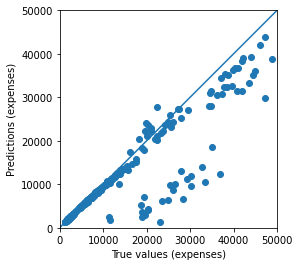

In [52]:
# RUN THIS CELL TO TEST YOUR MODEL. DO NOT MODIFY CONTENTS.
# Test model by checking how well the model generalizes using the test set.
loss, mae, mse = model.evaluate(test_set, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} expenses".format(mae))

if mae < 3500:
  print("You passed the challenge. Great job!")
else:
  print("The Mean Abs Error must be less than 3500. Keep trying.")

# Plot predictions.
test_predictions = model.predict(test_set).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True values (expenses)')
plt.ylabel('Predictions (expenses)')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims,lims)
